<a href="https://colab.research.google.com/github/andryll/MGR-IC/blob/main/codes/MGR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Setup


In [1]:
import numpy as np
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA

In [2]:
!git clone https://github.com/andryll/MGR-IC.git

Cloning into 'MGR-IC'...
remote: Enumerating objects: 1072, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 1072 (delta 24), reused 8 (delta 0), pack-reused 999
Receiving objects: 100% (1072/1072), 1.13 GiB | 29.32 MiB/s, done.
Resolving deltas: 100% (24/24), done.
Updating files: 100% (1004/1004), done.


###Leitura das Músicas

In [3]:
def readSongs (genre, numSongs, sr=44100):

  genrelist = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
                'metal', 'pop', 'reggae', 'rock']

  if genre != 'all':
    genrelist = [genre]

  songs = []

  for g in genrelist:

    dir_path = os.path.join('/content/MGR-IC/songs/', g)

    files = os.listdir(dir_path)
    files.sort

    for i in range(numSongs):
      songs.append(librosa.load(os.path.join(dir_path, files[i]), sr=sr, mono = True))
      songs[-1] = songs[-1] + (g,)
 # print(songs)

  min_len = min(len(song[0]) for song in songs)

  min_songs = []
  for song in songs:
      if len(song[0]) > min_len:
        start_trim = int((len(song[0]) - min_len) / 2)
        end_trim = len(song[0]) - start_trim
        trimmed_audio = librosa.util.normalize(song[0][start_trim:end_trim])
        min_songs.append(trimmed_audio)
      else:
        min_songs.append(song[0])

  new_songs = []
  for i in range(len(songs)):
    tupla = (min_songs[i], songs[i][1], songs[i][2])
    new_songs.append(tupla)

  return new_songs


###Extração das Features

In [6]:
def reduceDimension(dataframe, rate=0.99):
  X = dataframe.drop(columns=['Classe']).values.tolist()
  Y = dataframe['Classe'].values.tolist()

  scaler = preprocessing.StandardScaler()
  X_scaled = scaler.fit_transform(X)

  pca = PCA(n_components= rate)
  X_pca = pca.fit_transform(X_scaled)

  X = pd.DataFrame(X_pca)
  Y = pd.DataFrame({'Classe': Y})
  df = pd.concat([X, Y], axis=1)

  return df

In [109]:
def featureExtraction (songs, feature, sr=44100, frame=512):

  zcrlist = []
  rmslist = []
  mfcclist = []
  sctoidlist = []
  srlofflist = []
  alllist = []

  for i in songs:

    match feature:
      case 'zcr':
        zcr = librosa.feature.zero_crossing_rate(i[0], frame_length = frame, hop_length = round(frame/2), center = True)
        aux = pd.DataFrame(zcr[0]).transpose()
        aux['Classe'] = i[2]
        zcrlist.append(aux)

      case 'rms':
        rms = librosa.feature.rms(y=i[0], frame_length = frame, hop_length = round(frame/2), center = True)
        aux = pd.DataFrame(rms[0]).transpose()
        aux['Classe'] = i[2]
        rmslist.append(aux)

      case 'mfcc':
        mfcc = librosa.feature.mfcc(y=i[0], sr=sr)
        mfcc = (np.array(mfcc).flatten()).tolist()
        aux = pd.DataFrame(mfcc).transpose()
        aux['Classe'] = i[2]
        mfcclist.append(aux)

      case 'centroid':
        sctoid = librosa.feature.spectral_centroid(y=i[0], sr=sr, hop_length = round(frame/2), center = True)
        aux = pd.DataFrame(sctoid[0]).transpose()
        aux['Classe'] = i[2]
        sctoidlist.append(aux)

      case 'rolloff':
        srloff99 = librosa.feature.spectral_rolloff(y=i[0], sr=sr, hop_length = round(frame/2), center = True, roll_percent=0.95)
        srloff1 = librosa.feature.spectral_rolloff(y=i[0], sr=sr, hop_length = round(frame/2), center = True, roll_percent=0.05)
        aux1 = pd.DataFrame(srloff99)
        aux2 = pd.DataFrame(srloff1)
        aux = pd.concat([aux2, aux1], axis=1)
        aux['Classe'] = i[2]
        srlofflist.append(aux)

      case 'all':
        zcr = librosa.feature.zero_crossing_rate(i[0], frame_length = frame, hop_length = round(frame/2), center = True)
        zcrdf = pd.DataFrame(zcr[0]).transpose()

        rms = librosa.feature.rms(y=i[0], frame_length = frame, hop_length = round(frame/2), center = True)
        rmsdf = pd.DataFrame(rms[0]).transpose()

        mfcc = librosa.feature.mfcc(y=i[0], sr=sr)
        mfcc = (np.array(mfcc).flatten()).tolist()
        mfccdf = pd.DataFrame(mfcc).transpose()

        sctoid = librosa.feature.spectral_centroid(y=i[0], sr=sr, hop_length = round(frame/2), center = True)
        sctoiddf = pd.DataFrame(sctoid[0]).transpose()

        srloff99 = librosa.feature.spectral_rolloff(y=i[0], sr=sr, hop_length = round(frame/2), center = True, roll_percent=0.95)
        srloff1 = librosa.feature.spectral_rolloff(y=i[0], sr=sr, hop_length = round(frame/2), center = True, roll_percent=0.05)
        srloff99df = pd.DataFrame(srloff99)
        srloff1df = pd.DataFrame(srloff1)
        aux = pd.concat([zcrdf, rmsdf, mfccdf, sctoiddf, srloff1df, srloff99df], axis=1)
        aux['Classe'] = i[2]
        alllist.append(aux)

      case _:
        print('Feature Inválida')

  match feature:
    case 'zcr':
      dfzcr = pd.concat(zcrlist, axis=0)
      df = reduceDimension(dfzcr, 0.99)
      return df

    case 'rms':
      dfrms = pd.concat(rmslist, axis=0)
      df = reduceDimension(dfrms, 0.99)
      return df

    case 'mfcc':
      dfmfcc = pd.concat(mfcclist, axis=0)
      df = reduceDimension(dfmfcc, 0.99)
      return df

    case 'centroid':
      dfcentroid = pd.concat(sctoidlist, axis=0)
      df = reduceDimension(dfcentroid, 0.99)
      return df

    case 'rolloff':
      dfrolloff = pd.concat(srlofflist, axis=0)
      df = reduceDimension(dfrolloff, 0.99)
      return df

    case 'all':
      dfall = pd.concat(alllist, axis=0)
      df = reduceDimension(dfall, 0.99)
      return df

### Gráfico Cotovelo

In [8]:
def KFoldCrossValidation(dataframe, n_splits, seed):

    target = 'Classe'
    X_columns = dataframe.columns[dataframe.columns != target]
    X = dataframe[X_columns]
    Y = dataframe[target]

    skf = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state = seed)

    X_train_list = []
    X_test_list = []
    Y_train_list = []
    Y_test_list = []

    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        # Armazenar os vetores de treino e teste nas listas
        X_train_list.append(X_train.values.tolist())
        X_test_list.append(X_test.values.tolist())
        Y_train_list.append(Y_train.to_list())
        Y_test_list.append(Y_test.to_list())

    return X_train_list, X_test_list, Y_train_list, Y_test_list

In [9]:
def elbowKNN(dflist, n_neigh, seed):


  scorelist = []

  for df in dflist:
    neigh = neighbors.KNeighborsClassifier(n_neighbors= n_neigh)

    X_train, X_test, Y_train, Y_test = KFoldCrossValidation(df, n_splits = 10, seed = seed)

    auxlist = []

    for i in range(10):

        neigh.fit(X_train[i], Y_train[i])
        Y_predict = neigh.predict(X_test[i])
        #auxlist.append(f1_score(Y_test[i], Y_predict, average='weighted'))
        auxlist.append(balanced_accuracy_score(Y_test[i], Y_predict))

    scorelist.append(np.mean(np.array(auxlist), axis = 0))

  return scorelist

In [10]:
def elbowTree(dflist, seed):

  scorelist = []

  for df in dflist:
    clf = tree.DecisionTreeClassifier(random_state = seed)

    X_train, X_test, Y_train, Y_test = KFoldCrossValidation(df, n_splits = 10, seed = seed)

    auxlist = []

    for i in range(10):

        clf.fit(X_train[i], Y_train[i])
        Y_predict = clf.predict(X_test[i])
        # auxlist.append(f1_score(Y_test[i], Y_predict, average='weighted'))
        auxlist.append(balanced_accuracy_score(Y_test[i], Y_predict))

    scorelist.append(np.mean(np.array(auxlist), axis = 0))

  return scorelist


In [11]:
def elbowRF(dflist, seed):

  scorelist = []

  for df in dflist:
    rf = ensemble.RandomForestClassifier(random_state = seed)

    X_train, X_test, Y_train, Y_test = KFoldCrossValidation(df, n_splits = 10, seed = seed)

    auxlist = []

    for i in range(10):

        rf.fit(X_train[i], Y_train[i])
        Y_predict = rf.predict(X_test[i])
        # auxlist.append(f1_score(Y_test[i], Y_predict, average='weighted'))
        auxlist.append(balanced_accuracy_score(Y_test[i], Y_predict))

    scorelist.append(np.mean(np.array(auxlist), axis = 0))

  return scorelist

### Testes

In [72]:
songs = readSongs ('all', 50, 44100)
# [df, df2] = featureExtraction (songs, 'rolloff', 44100)
# df.head()
# df2.head()

In [75]:
frame_lenghts = [256, 512, 1024, 2048, 4096, 8192]

dflist = []
for f in frame_lenghts:
  dflist.append(featureExtraction(songs, 'centroid', 44100, frame=f))

#dflist[3].head()

In [90]:
dflist[5].head

<bound method NDFrame.head of              0          1         2         3         4         5         6  \
0     6.967701 -10.239691 -0.383842  0.442480  0.956373 -0.784730 -0.179138   
1     5.530423   9.001004 -0.075353 -0.368337 -2.114324  1.166228 -0.647314   
2    14.602837   9.199562  1.416418 -1.059569 -1.031509 -0.894455  2.031318   
3    16.521745   4.119861  1.900241 -1.213092  0.251634  3.164671 -1.682109   
4     4.805221 -11.453169  0.543424  0.550869  0.830135  0.545659 -0.117724   
..         ...        ...       ...       ...       ...       ...       ...   
495   3.136734 -10.439623 -0.315608 -0.617222  0.664387 -0.133727  0.362105   
496   0.966485  10.629503 -2.241266 -0.766854 -0.944912 -1.997119 -3.993883   
497 -16.235839   5.948103  1.619680 -1.550752  1.683221 -0.163961  3.622729   
498  -7.604716 -11.902510  0.669884 -0.339362  0.748378  0.703410 -0.295301   
499  -1.540092 -18.111995  0.531596 -0.535548  2.543995  2.918867 -2.442591   

            7        

In [145]:
frame_lenghts = [256, 512, 1024, 2048, 4096, 8192]

dflist = []
for f in frame_lenghts:
  dflist.append(featureExtraction(songs, 'all', 44100, frame=f))

knnscores3 = []
knnscores5 = []
knnscores7 = []
dtscores = []
rfscores = []
seeds = [14, 42, 60, 87, 113, 156, 211, 456, 917, 1001]

for seed in seeds:
  knnscores3.append(elbowKNN(dflist, n_neigh = 3, seed = seed))
  knnscores5.append(elbowKNN(dflist, n_neigh = 5, seed = seed))
  knnscores7.append(elbowKNN(dflist, n_neigh = 7, seed = seed))

  dtscores.append(elbowTree(dflist, seed = seed))
  rfscores.append(elbowRF(dflist, seed = seed))

In [149]:
scoreslist = []
scoresmeans = []
scoressds = []

scoreslist.append(np.array(knnscores3))
scoreslist.append(np.array(knnscores5))
scoreslist.append(np.array(knnscores7))
scoreslist.append(np.array(dtscores))
scoreslist.append(np.array(rfscores))

# KNN3 = 0 / KNN5 = 1 / KNN7 = 2 / DT = 3 / RF = 4

for score in scoreslist:
  scoresmeans.append(np.mean(score, axis=0))
  scoressds.append(np.std(score, axis=0))


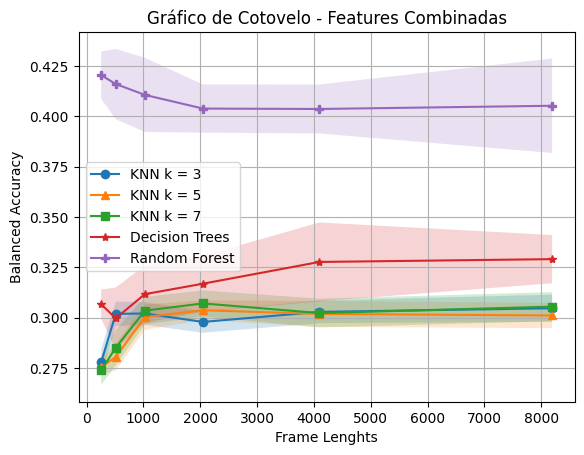

In [150]:
plt.plot(frame_lenghts, scoresmeans[0], label = 'KNN k = 3', marker = 'o')
plt.plot(frame_lenghts, scoresmeans[1], label = 'KNN k = 5', marker = '^')
plt.plot(frame_lenghts, scoresmeans[2], label = 'KNN k = 7', marker = 's')
plt.plot(frame_lenghts, scoresmeans[3], label = 'Decision Trees', marker = '*')
plt.plot(frame_lenghts, scoresmeans[4], label = 'Random Forest', marker = 'P')

plt.fill_between(frame_lenghts, scoresmeans[0] + scoressds[0], scoresmeans[0] - scoressds[0], alpha = 0.2)
plt.fill_between(frame_lenghts, scoresmeans[1] + scoressds[1], scoresmeans[1] - scoressds[1], alpha = 0.2)
plt.fill_between(frame_lenghts, scoresmeans[2] + scoressds[2], scoresmeans[2] - scoressds[2], alpha = 0.2)
plt.fill_between(frame_lenghts, scoresmeans[3] + scoressds[3], scoresmeans[3] - scoressds[3], alpha = 0.2)
plt.fill_between(frame_lenghts, scoresmeans[4] + scoressds[4], scoresmeans[4] - scoressds[4], alpha = 0.2)

plt.legend()
plt.grid()
plt.ylabel('Balanced Accuracy')
plt.xlabel('Frame Lenghts')
plt.title('Gráfico de Cotovelo - Features Combinadas')
plt.savefig('all.pdf')
plt.show()


In [ ]:
  dfmfcc = featureExtraction(songs, 'mfcc', 44100, frame=1024)


In [ ]:
dfmfcc

,0,1,2,3,4,5,6,7,8,9,...,462,463,464,465,466,467,468,469,470,Classe
0,-116.939951,113.042750,-65.753086,12.344498,-24.937102,-70.500924,13.027312,-28.104026,-40.502996,6.617219,...,0.846673,-1.661051,0.247780,-0.302222,0.685317,0.878986,-1.609223,2.749904,-1.204382,blues
1,-74.198796,24.963467,-31.119173,29.400915,-27.855362,41.175375,0.479453,-36.574666,-55.706591,-28.475409,...,-0.969790,3.338311,2.547386,0.809207,1.803231,3.827630,-1.635539,2.101561,-0.388871,blues
2,-130.457468,70.523734,3.163108,14.679926,-25.755561,-64.609653,33.410701,-50.321242,-19.442909,-4.449357,...,1.360602,3.158647,-1.060377,0.444281,-0.215253,1.313264,3.703139,0.640166,-0.514204,blues
3,-51.720317,-138.918637,13.823546,14.593035,-25.788637,-27.247902,-15.325501,-11.304335,10.885760,-40.467194,...,-0.551907,-0.890012,2.945757,-3.510252,-4.720336,7.655679,-2.436163,-10.084106,1.300886,blues
4,-43.344591,-52.673227,-50.205891,85.165290,-1.909912,-0.650351,35.103971,-43.039959,-9.574544,-21.732105,...,-1.507285,-2.055788,-4.121975,-3.059174,-12.247314,-2.344600,-10.558266,-1.076046,0.889968,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-15.094397,-114.955877,38.882260,-2.763748,-10.059732,14.317047,2.866241,1.617976,-3.197187,13.071280,...,-4.972391,0.626081,-10.460178,1.441559,-8.615187,-4.247495,0.623409,7.630507,-9.590981,rock
496,-37.521159,-100.279896,78.979590,-3.365867,13.911065,21.787959,0.599574,4.700052,0.790283,11.785468,...,8.794680,4.105937,-3.115178,10.020883,-3.867006,0.121075,-5.453672,-3.905590,3.025838,rock
497,-69.112497,0.226394,12.226294,29.718094,36.412647,-42.205396,-18.993230,22.470375,-3.457585,-2.351191,...,0.736789,0.768406,1.631176,-0.801720,-1.631423,0.739204,2.566828,0.246605,1.215980,rock
498,-42.129092,-101.850000,13.738344,-19.683156,-11.206048,-2.063262,-3.428213,11.189964,1.177718,-18.203325,...,-2.328715,-4.399809,-2.771646,-1.017010,4.260203,-0.780695,-4.113034,3.619867,-2.420794,rock


In [ ]:
knnscores3 = []
knnscores5 = []
knnscores7 = []
dtscores = []
rfscores = []
seeds = [14, 42, 60, 87, 113, 156, 211, 456, 917, 1001]

for seed in seeds:
  knnscores3.append(elbowKNN([dfmfcc], n_neigh = 3, seed = seed))
  knnscores5.append(elbowKNN([dfmfcc], n_neigh = 5, seed = seed))
  knnscores7.append(elbowKNN([dfmfcc], n_neigh = 7, seed = seed))

  dtscores.append(elbowTree([dfmfcc], seed = seed))
  rfscores.append(elbowRF([dfmfcc], seed = seed))


In [ ]:
knn3 = (np.array(knnscores3).flatten()).tolist()
knn5 = (np.array(knnscores5).flatten()).tolist()
knn7 = (np.array(knnscores7).flatten()).tolist()
dt = (np.array(dtscores).flatten()).tolist()
rf = (np.array(rfscores).flatten()).tolist()

boxplot = []
boxplot.append(knn3)
boxplot.append(knn5)
boxplot.append(knn7)
boxplot.append(dt)
boxplot.append(rf)

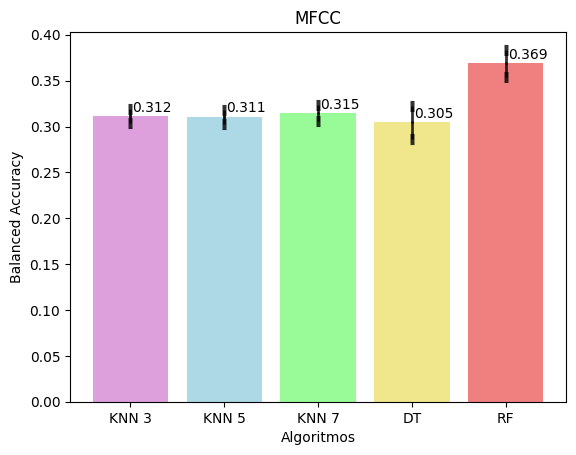

In [ ]:
# algs = ['KNN 3', 'KNN 5', 'KNN 7', 'DT', 'RF']

# def addlabels(x,y):
#     for i in range(len(x)):
#         plt.text(i+0.02, y[i] + 0.005, round(y[i], 3))

# plt.bar(algs, sm, color=['plum','lightblue','palegreen','khaki','lightcoral'])
# plt.errorbar(algs,sm,sd,fmt='.',color='Black', elinewidth=2,capthick=8,errorevery=1, alpha=0.8, ms=2, capsize = 1.5)
# plt.ylabel('Balanced Accuracy')
# plt.xlabel('Algoritmos')

# addlabels(algs, sm)

# plt.title('MFCC')
# plt.savefig('mfcc.pdf')
# plt.show()

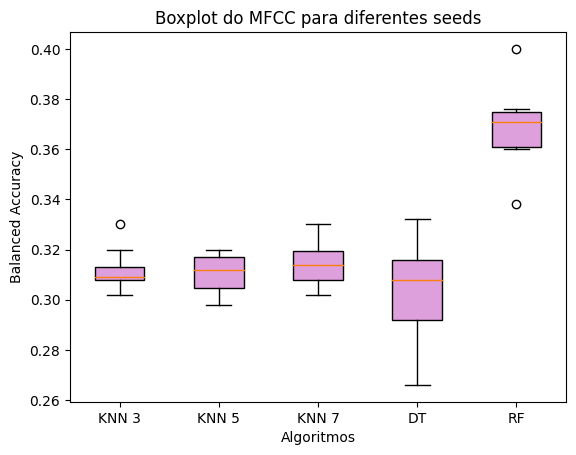

In [ ]:
algs = ['KNN 3', 'KNN 5', 'KNN 7', 'DT', 'RF']
cores= ['red','green','purple','orange','blue']
box = plt.boxplot(boxplot, labels=algs, patch_artist=True,
            boxprops=dict(facecolor='plum', color='black'))

plt.title('Boxplot do MFCC para diferentes seeds')
plt.xlabel('Algoritmos')
plt.ylabel('Balanced Accuracy')

plt.savefig('mfcc.pdf')
plt.show()

In [137]:
frame = 2048
sr = 44100
song = [songs[4], songs[14]]


In [138]:
#df = featureExtraction([songs[5]], 'all', 44100, frame=f)
alllist = []

for i in song:

  zcr = librosa.feature.zero_crossing_rate(i[0], frame_length = frame, hop_length = round(frame/2), center = True)
  zcrdf = pd.DataFrame(zcr[0]).transpose()

  rms = librosa.feature.rms(y=i[0], frame_length = frame, hop_length = round(frame/2), center = True)
  rmsdf = pd.DataFrame(rms[0]).transpose()

  mfcc = librosa.feature.mfcc(y=i[0], sr=sr)
  mfcc = (np.array(mfcc).flatten()).tolist()
  mfccdf = pd.DataFrame(mfcc).transpose()

  sctoid = librosa.feature.spectral_centroid(y=i[0], sr=sr, hop_length = round(frame/2), center = True)
  sctoiddf = pd.DataFrame(sctoid[0]).transpose()

  srloff99 = librosa.feature.spectral_rolloff(y=i[0], sr=sr, hop_length = round(frame/2), center = True, roll_percent=0.95)
  srloff1 = librosa.feature.spectral_rolloff(y=i[0], sr=sr, hop_length = round(frame/2), center = True, roll_percent=0.05)
  srloff99df = pd.DataFrame(srloff99)
  srloff1df = pd.DataFrame(srloff1)
  aux = pd.concat([zcrdf, rmsdf, mfccdf, sctoiddf, srloff1df, srloff99df], axis=1)
  aux['Classe'] = i[2]
  alllist.append(aux)

In [143]:
dfall = pd.concat(alllist, axis=0)
dfall.head()

df = reduceDimension(dfall, 0.99)

In [135]:
df = featureExtraction(i, 'all', 44100, frame=1024)

In [144]:
df.head()

,0,Classe
0,-240.437102,blues
1,240.437102,blues
